## 1. Imports

In [126]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import (
    DecisionTreeClassifier
)

from sklearn.neighbors import (
    KNeighborsClassifier
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)

from xgboost import XGBClassifier

from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import OneHotEncoder

## 2. Dados

In [2]:
df_test = pd.read_csv("./data/test.csv")
df = pd.read_csv("./data/train.csv")

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def plot_number(df: pd.DataFrame, index: int) -> None:
    plt.imshow(np.array(df.iloc[index]).reshape((28, 28)))

## 3. AED

### 3.1. Eliminando pixels não usados

In [5]:
take_number = lambda x: int(x.split("pixel")[1])

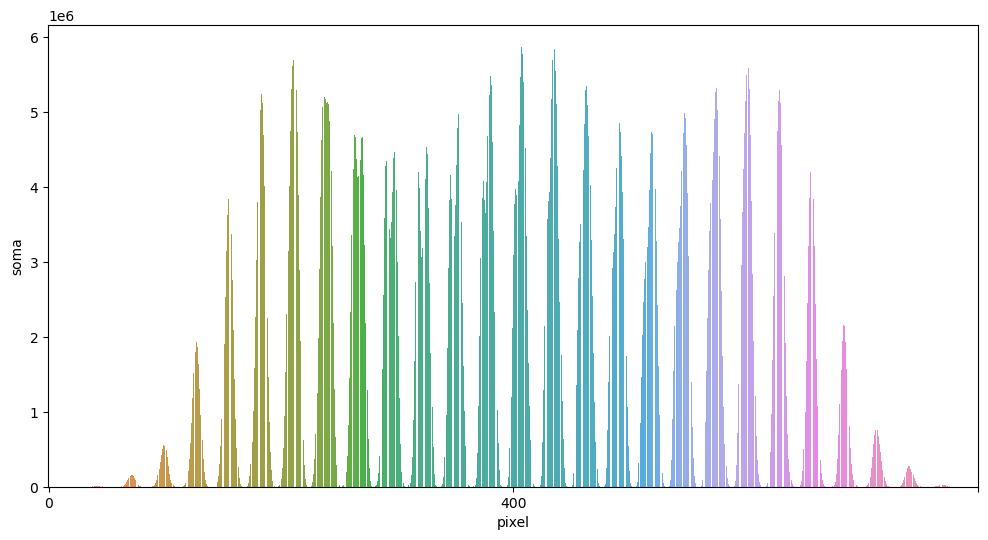

In [6]:
sum_by_pixel = pd.DataFrame(df.sum().drop("label")).reset_index()

sum_by_pixel.columns = ["pixel", "soma"]

sum_by_pixel["pixel"] = sum_by_pixel["pixel"].apply(take_number)

plt.figure(figsize=(12, 6))

sns.barplot(sum_by_pixel, x="pixel", y="soma")

plt.xticks([0, 400, 800])

plt.show()

In [7]:
columns_mt_zero = list(("pixel" + sum_by_pixel[sum_by_pixel["soma"] > 0]["pixel"].astype(str)).values)

### 3.2. Correlação

In [8]:
df_low_corr = df.copy()

In [9]:
ohe = OneHotEncoder()

In [10]:
labels_values = np.array(df_low_corr["label"]).reshape((-1, 1))

In [11]:
labels_encodes = ohe.fit_transform(labels_values).toarray()

labels_categories = ohe.categories_[0]

In [12]:
labels_categories = ("label" + pd.Series(labels_categories).astype(str)).values

In [13]:
df_low_corr.loc[:, labels_categories] = labels_encodes

In [14]:
df_low_corr[labels_categories]

,label0,label1,label2,label3,label4,label5,label6,label7,label8,label9
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
41995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
df_corr = df_low_corr.corr()

df_corr = df_corr[labels_categories].drop(["label"] + list(labels_categories), axis=0)

df_corr["pixel"] = pd.Series(df_corr.index).apply(take_number).values

df_corr = df_corr.reset_index(drop=True)

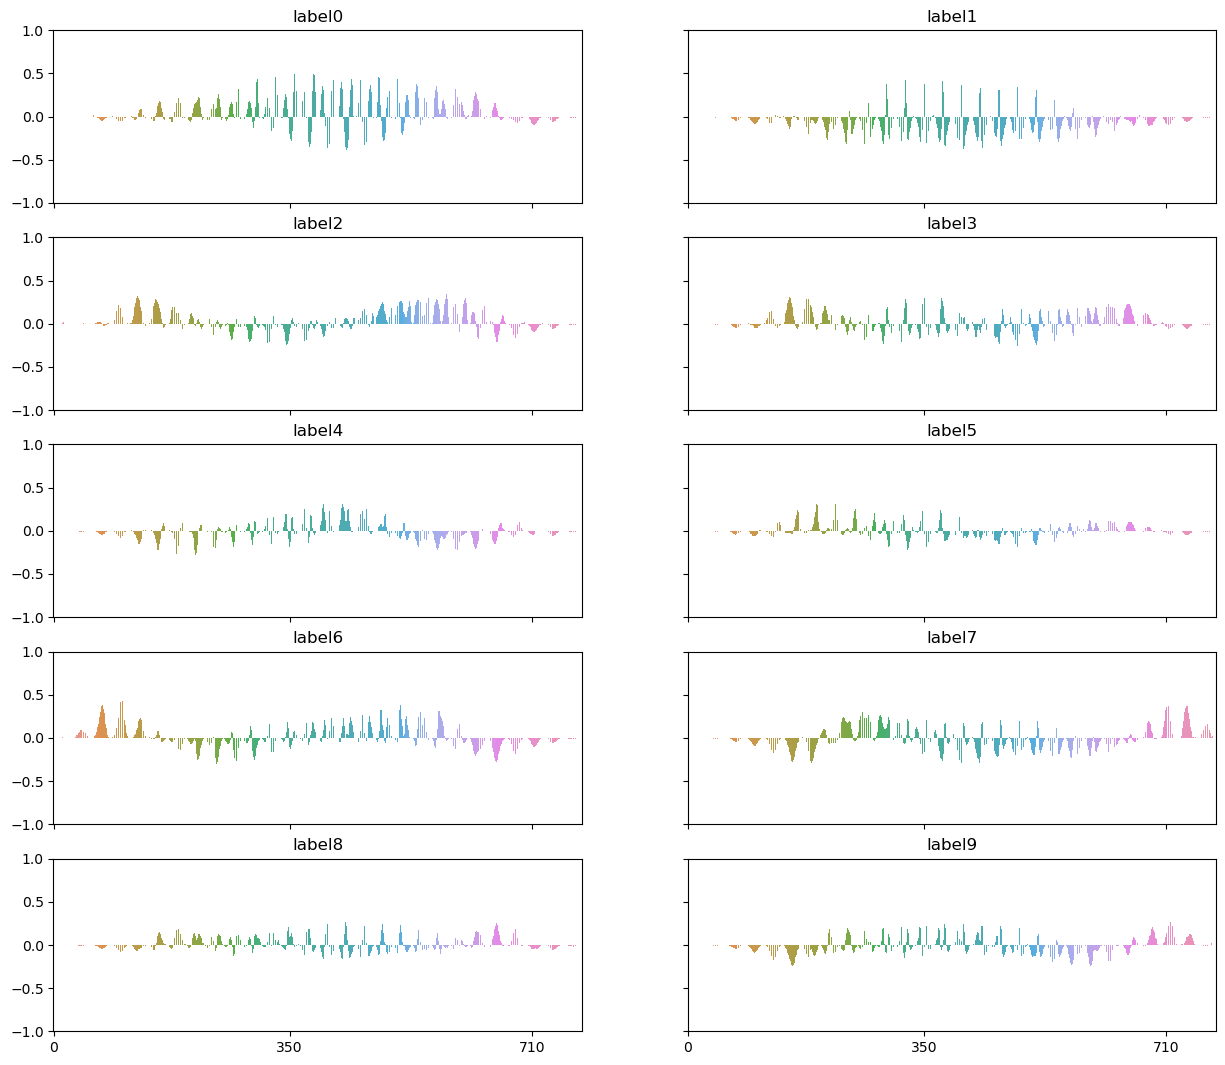

In [16]:
fig, axs = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(15, 13))

for i, label in enumerate(labels_categories):
    j = i // 2
    k = i % 2

    sns.barplot(df_corr, x="pixel", y=label, ax=axs[i // 2, i % 2])

    axs[j, k].set_ylim([-1, 1])

    axs[j, k].set_xticks([0, 350, 710])

    axs[j, k].set_xlabel("")

    axs[j, k].set_ylabel("")

    axs[j, k].set_title("label" + str(i))

plt.show()

In [17]:
def get_columns_above_limiar_corr(df_corr, limiar) -> np.array:

    qtd_low_corr_by_pixel = (
        (df_corr.drop("pixel", axis=1) >= -limiar) &
        (df_corr.drop("pixel", axis=1) <= limiar)
    ).T.sum() == 10

    cols_down_limiar = set(qtd_low_corr_by_pixel[qtd_low_corr_by_pixel].index)
    cols_above_limiar = set(qtd_low_corr_by_pixel.index) - cols_down_limiar

    return ("pixel" + qtd_low_corr_by_pixel[list(cols_above_limiar)].index.astype(str)).values

In [18]:
columns_above_lcorr_025 = get_columns_above_limiar_corr(df_corr, 0.025)
columns_above_lcorr_050 = get_columns_above_limiar_corr(df_corr, 0.050)
columns_above_lcorr_075 = get_columns_above_limiar_corr(df_corr, 0.075)
columns_above_lcorr_100 = get_columns_above_limiar_corr(df_corr, 0.100)
columns_above_lcorr_150 = get_columns_above_limiar_corr(df_corr, 0.15)
columns_above_lcorr_200 = get_columns_above_limiar_corr(df_corr, 0.20)
columns_above_lcorr_250 = get_columns_above_limiar_corr(df_corr, 0.25)
columns_above_lcorr_300 = get_columns_above_limiar_corr(df_corr, 0.30)

## 4. Treino e Teste

### 4.1. Conjuntos

In [19]:
qtd_col_by_filtro = {
    "total": df.shape[1],
    "cols_mt_zero": df[columns_mt_zero].shape[1],
    "cols_ab_l0.300": df[columns_above_lcorr_300].shape[1],
    "cols_ab_l0.250": df[columns_above_lcorr_250].shape[1],
    "cols_ab_l0.200": df[columns_above_lcorr_200].shape[1],
    "cols_ab_l0.150": df[columns_above_lcorr_150].shape[1],
    "cols_ab_l0.100": df[columns_above_lcorr_100].shape[1],
    "cols_ab_l0.075": df[columns_above_lcorr_075].shape[1],
    "cols_ab_l0.050": df[columns_above_lcorr_050].shape[1],
    "cols_ab_l0.025": df[columns_above_lcorr_025].shape[1],
    "cols_mt_zero and cols_ab_l0.300": df[list(set(columns_mt_zero) & set(columns_above_lcorr_300))].shape[1],
    "cols_mt_zero and cols_ab_l0.250": df[list(set(columns_mt_zero) & set(columns_above_lcorr_250))].shape[1],
    "cols_mt_zero and cols_ab_l0.200": df[list(set(columns_mt_zero) & set(columns_above_lcorr_200))].shape[1],
    "cols_mt_zero and cols_ab_l0.150": df[list(set(columns_mt_zero) & set(columns_above_lcorr_150))].shape[1],
    "cols_mt_zero and cols_ab_l0.100": df[list(set(columns_mt_zero) & set(columns_above_lcorr_100))].shape[1],
    "cols_mt_zero and cols_ab_l0.075": df[list(set(columns_mt_zero) & set(columns_above_lcorr_075))].shape[1],
    "cols_mt_zero and cols_ab_l0.050": df[list(set(columns_mt_zero) & set(columns_above_lcorr_050))].shape[1],
    "cols_mt_zero and cols_ab_l0.025": df[list(set(columns_mt_zero) & set(columns_above_lcorr_025))].shape[1],
}

In [20]:
pd.Series(qtd_col_by_filtro)

total                              785
cols_mt_zero                       708
cols_ab_l0.300                     226
cols_ab_l0.250                     369
cols_ab_l0.200                     469
cols_ab_l0.150                     544
cols_ab_l0.100                     601
cols_ab_l0.075                     633
cols_ab_l0.050                     674
cols_ab_l0.025                     712
cols_mt_zero and cols_ab_l0.300    150
cols_mt_zero and cols_ab_l0.250    293
cols_mt_zero and cols_ab_l0.200    393
cols_mt_zero and cols_ab_l0.150    468
cols_mt_zero and cols_ab_l0.100    525
cols_mt_zero and cols_ab_l0.075    557
cols_mt_zero and cols_ab_l0.050    598
cols_mt_zero and cols_ab_l0.025    636
dtype: int64

In [21]:
df_01 = df[["label"] + columns_mt_zero]
df_02 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_300))]
df_03 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_250))]
df_04 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_200))]
df_05 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_150))]
df_06 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_100))]
df_07 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_075))]
df_08 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_050))]
df_09 = df[["label"] + list(set(columns_mt_zero) & set(columns_above_lcorr_025))]

### 4.2. Separação

In [22]:
seed = 94

In [23]:
X_training_01, y_training_01 = df_01.drop("label", axis=1), df_01["label"]
X_training_02, y_training_02 = df_02.drop("label", axis=1), df_02["label"]
X_training_03, y_training_03 = df_03.drop("label", axis=1), df_03["label"]
X_training_04, y_training_04 = df_04.drop("label", axis=1), df_04["label"]
X_training_05, y_training_05 = df_05.drop("label", axis=1), df_05["label"]
X_training_06, y_training_06 = df_06.drop("label", axis=1), df_06["label"]
X_training_07, y_training_07 = df_07.drop("label", axis=1), df_07["label"]
X_training_08, y_training_08 = df_08.drop("label", axis=1), df_08["label"]
X_training_09, y_training_09 = df_09.drop("label", axis=1), df_09["label"]

In [24]:
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(X_training_01, y_training_01, random_state=seed, test_size=0.33, stratify=y_training_01)
X_train_02, X_val_02, y_train_02, y_val_02 = train_test_split(X_training_02, y_training_02, random_state=seed, test_size=0.33, stratify=y_training_02)
X_train_03, X_val_03, y_train_03, y_val_03 = train_test_split(X_training_03, y_training_03, random_state=seed, test_size=0.33, stratify=y_training_03)
X_train_04, X_val_04, y_train_04, y_val_04 = train_test_split(X_training_04, y_training_04, random_state=seed, test_size=0.33, stratify=y_training_04)
X_train_05, X_val_05, y_train_05, y_val_05 = train_test_split(X_training_05, y_training_05, random_state=seed, test_size=0.33, stratify=y_training_05)
X_train_06, X_val_06, y_train_06, y_val_06 = train_test_split(X_training_06, y_training_06, random_state=seed, test_size=0.33, stratify=y_training_06)
X_train_07, X_val_07, y_train_07, y_val_07 = train_test_split(X_training_07, y_training_07, random_state=seed, test_size=0.33, stratify=y_training_07)
X_train_08, X_val_08, y_train_08, y_val_08 = train_test_split(X_training_08, y_training_08, random_state=seed, test_size=0.33, stratify=y_training_08)
X_train_09, X_val_09, y_train_09, y_val_09 = train_test_split(X_training_09, y_training_09, random_state=seed, test_size=0.33, stratify=y_training_09)

## 5. Classificação

### 5.1. Árvore de Decisão

#### 5.1.1. Teste de Produndidade Máxima

In [395]:
tree = DecisionTreeClassifier(
    random_state=seed,
    max_depth=12
)

tree.fit(X_train_02, y_train_02)

y_pred = tree.predict(X_val_02)

print("Acurácia no conjunto de treino: {:.3f}".format(tree.score(X_train_02, y_train_02)))
print("Acurácia no conjunto de validação: {:.3f}".format(tree.score(X_val_02, y_val_02)))
print(classification_report(y_val_02, y_pred))

Acurácia no conjunto de treino: 0.927
Acurácia no conjunto de validação: 0.807
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1364
           1       0.91      0.95      0.93      1546
           2       0.82      0.78      0.80      1378
           3       0.78      0.75      0.77      1436
           4       0.70      0.74      0.72      1344
           5       0.76      0.73      0.75      1252
           6       0.87      0.84      0.85      1365
           7       0.85      0.86      0.86      1452
           8       0.75      0.76      0.75      1341
           9       0.70      0.71      0.71      1382

    accuracy                           0.81     13860
   macro avg       0.81      0.80      0.80     13860
weighted avg       0.81      0.81      0.81     13860



#### 5.1.2. Escolhendo Hiperparâmetros

In [30]:
parameters = {
    'max_depth': [10, 13, 15],
    'criterion': ['gini', 'entropy', 'log_loss']
}

tree = DecisionTreeClassifier(random_state=seed)

grid = GridSearchCV(tree, parameters)

grid.fit(X_train_01, y_train_01)

params_tree = grid.best_params_

params_tree['random_state'] = seed

params_tree

{'criterion': 'entropy', 'max_depth': 15}

#### 5.1.3. Teste de Subconjuntos de Variáveis

In [86]:
def get_results_model(x_train, y_train, x_val, y_val, model, params):

    tree = model(**params)

    tree.fit(x_train.values, y_train.values)

    y_pred = tree.predict(x_val.values)

    print("Acurácia no conjunto de treino: {:.3f}".format(tree.score(x_train.values, y_train.values)))
    print("Acurácia no conjunto de validação: {:.3f}".format(tree.score(x_val.values, y_val.values)))
    print(classification_report(y_val.values, y_pred))

In [55]:
"""
01 - 0.860
02 - 0.826
03 - 0.861
04 - 0.860
05 - 0.860
"""
None

In [87]:
get_results_model(X_train_01, y_train_01, X_val_01, y_val_01, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_02, y_train_02, X_val_02, y_val_02, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_03, y_train_03, X_val_03, y_val_03, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_04, y_train_04, X_val_04, y_val_04, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_05, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_06, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_07, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_08, DecisionTreeClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_09, DecisionTreeClassifier, params_tree)

TypeError: __init__() got an unexpected keyword argument 'n_neighbors'

### 5.2. Floresta Aleatória

#### 5.2.1. Teste de Subconjuntos de Variáveis

In [65]:
"""
01 - 0.961
02 - 0.921
03 - 0.956
04 - 0.960
05 - 0.961
06 - 0.961
07 - 0.961
08 - 0.961
09 - 0.961
"""
None

In [64]:
get_results_model(X_train_01, y_train_01, X_val_01, y_val_01, RandomForestClassifier, params_tree)
#get_results_model(X_train_02, y_train_02, X_val_02, y_val_02, RandomForestClassifier, params_tree)
#get_results_model(X_train_03, y_train_03, X_val_03, y_val_03, RandomForestClassifier, params_tree)
#get_results_model(X_train_04, y_train_04, X_val_04, y_val_04, RandomForestClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_05, RandomForestClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_06, RandomForestClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_07, RandomForestClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_08, RandomForestClassifier, params_tree)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_09, RandomForestClassifier, params_tree)

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.961
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1364
           1       0.98      0.98      0.98      1546
           2       0.96      0.97      0.96      1378
           3       0.95      0.94      0.95      1436
           4       0.96      0.96      0.96      1344
           5       0.96      0.96      0.96      1252
           6       0.96      0.98      0.97      1365
           7       0.97      0.95      0.96      1452
           8       0.96      0.94      0.95      1341
           9       0.93      0.95      0.94      1382

    accuracy                           0.96     13860
   macro avg       0.96      0.96      0.96     13860
weighted avg       0.96      0.96      0.96     13860



### 5.3. KNN

#### 5.3.1. Teste com N

In [77]:
"""
03 - tre: 954, val: 916
04 - tre: 944, val: 912
05 - tre: 943, val: 915
06 - tre: 938, val: 911
"""
None

In [76]:
knn = KNeighborsClassifier(
    n_neighbors=6
)

knn.fit(X_train_02.values, y_train_02.values)

y_pred = knn.predict(X_val_02.values)

print("Acurácia no conjunto de treino: {:.3f}".format(knn.score(X_train_02.values, y_train_02.values)))
print("Acurácia no conjunto de validação: {:.3f}".format(knn.score(X_val_02.values, y_val_02.values)))
print(classification_report(y_val_02.values, y_pred))

Acurácia no conjunto de treino: 0.938
Acurácia no conjunto de validação: 0.911
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1364
           1       0.89      0.99      0.94      1546
           2       0.94      0.89      0.92      1378
           3       0.87      0.93      0.90      1436
           4       0.86      0.85      0.85      1344
           5       0.92      0.87      0.89      1252
           6       0.97      0.94      0.95      1365
           7       0.92      0.92      0.92      1452
           8       0.95      0.86      0.90      1341
           9       0.86      0.85      0.86      1382

    accuracy                           0.91     13860
   macro avg       0.91      0.91      0.91     13860
weighted avg       0.91      0.91      0.91     13860



#### 5.3.2. Escolhendo Hiperparâmetros

In [83]:
parameters = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, parameters)

grid.fit(X_train_01.values, y_train_01.values)

params_knn = grid.best_params_

params_knn

{'n_neighbors': 4, 'weights': 'distance'}

#### 5.3.3. Teste de Subconjuntos de Variáveis

In [100]:
"""
01 - tre: 1000, val: 966
02 - tre: 1000, val: 920
03 - tre: 1000, val: 964
04 - tre: 1000, val: 966
05 - tre: 1000, val: 967
06 - tre: 1000, val: 967
07 - tre: 1000, val: 967
08 - tre: 1000, val: 967
09 - tre: 1000, val: 967
"""
None

In [99]:
get_results_model(X_train_01, y_train_01, X_val_01, y_val_01, KNeighborsClassifier, params_knn)
#get_results_model(X_train_02, y_train_02, X_val_02, y_val_02, KNeighborsClassifier, params_knn)
#get_results_model(X_train_03, y_train_03, X_val_03, y_val_03, KNeighborsClassifier, params_knn)
#get_results_model(X_train_04, y_train_04, X_val_04, y_val_04, KNeighborsClassifier, params_knn)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_05, KNeighborsClassifier, params_knn)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_06, KNeighborsClassifier, params_knn)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_07, KNeighborsClassifier, params_knn)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_08, KNeighborsClassifier, params_knn)
#get_results_model(X_train_05, y_train_05, X_val_05, y_val_09, KNeighborsClassifier, params_knn)

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.967
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1364
           1       0.96      0.99      0.97      1546
           2       0.98      0.96      0.97      1378
           3       0.96      0.96      0.96      1436
           4       0.98      0.96      0.97      1344
           5       0.95      0.96      0.95      1252
           6       0.98      0.98      0.98      1365
           7       0.96      0.97      0.97      1452
           8       0.99      0.92      0.95      1341
           9       0.94      0.96      0.95      1382

    accuracy                           0.97     13860
   macro avg       0.97      0.97      0.97     13860
weighted avg       0.97      0.97      0.97     13860



### 5.4. AdaBoost

In [122]:
def get_results_ada(x_train, y_train, x_val, y_val, model, params):

    ada = AdaBoostClassifier(
        random_state=seed, 
        estimator=model(**params)
    )

    ada.fit(x_train, y_train)

    y_pred = ada.predict(x_val)

    print("Acurácia no conjunto de treino: {:.3f}".format(ada.score(x_train, y_train)))
    print("Acurácia no conjunto de validação: {:.3f}".format(ada.score(x_val, y_val)))
    print(classification_report(y_val, y_pred))

#### 5.4.1. Teste com Árvore de Decisão

In [113]:
"""
01 - tre: 1000, val: 923
02 - 

"""
None

In [112]:
get_results_ada(X_train_01, y_train_01, X_val_01, y_val_01, DecisionTreeClassifier, params_tree)
#get_results_ada(X_train_02, y_train_02, X_val_02, y_val_02, DecisionTreeClassifier, params_tree)
#get_results_ada(X_train_03, y_train_03, X_val_03, y_val_03, DecisionTreeClassifier, params_tree)

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.923
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1364
           1       0.97      0.98      0.97      1546
           2       0.92      0.93      0.92      1378
           3       0.90      0.91      0.91      1436
           4       0.88      0.87      0.88      1344
           5       0.90      0.91      0.91      1252
           6       0.96      0.95      0.95      1365
           7       0.94      0.92      0.93      1452
           8       0.92      0.91      0.91      1341
           9       0.87      0.86      0.87      1382

    accuracy                           0.92     13860
   macro avg       0.92      0.92      0.92     13860
weighted avg       0.92      0.92      0.92     13860



#### 5.4.2. Teste com Floresta Aleatória

In [109]:
"""
01 - tre: 999, val: 915
02 - tre: 999, val: 915
"""
None

In [106]:
get_results_ada(X_train_01, y_train_01, X_val_01, y_val_01, RandomForestClassifier, params_tree)
#get_results_ada(X_train_02, y_train_02, X_val_02, y_val_02, RandomForestClassifier, params_tree)

Acurácia no conjunto de treino: 0.999
Acurácia no conjunto de validação: 0.915
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1364
           1       0.95      0.97      0.96      1546
           2       0.94      0.91      0.92      1378
           3       0.89      0.91      0.90      1436
           4       0.87      0.85      0.86      1344
           5       0.89      0.90      0.90      1252
           6       0.95      0.95      0.95      1365
           7       0.93      0.91      0.92      1452
           8       0.90      0.91      0.90      1341
           9       0.86      0.86      0.86      1382

    accuracy                           0.91     13860
   macro avg       0.91      0.91      0.91     13860
weighted avg       0.91      0.91      0.91     13860



### 5.5. HistGradientBoost

In [124]:
def get_results_gradient(x_train, y_train, x_val, y_val):

    grd = HistGradientBoostingClassifier(random_state=seed)

    grd.fit(x_train, y_train)

    y_pred = grd.predict(x_val)

    print("Acurácia no conjunto de treino: {:.3f}".format(grd.score(x_train, y_train)))
    print("Acurácia no conjunto de validação: {:.3f}".format(grd.score(x_val, y_val)))
    print(classification_report(y_val, y_pred))

In [121]:
"""
01 - tre: 997, val: 970
02 - 
"""
None

In [125]:
get_results_gradient(X_train_01, y_train_01, X_val_01, y_val_01)
#get_results_gradient(X_train_02, y_train_02, X_val_02, y_val_02)

Acurácia no conjunto de treino: 0.997
Acurácia no conjunto de validação: 0.970
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1364
           1       0.98      0.98      0.98      1546
           2       0.96      0.97      0.97      1378
           3       0.97      0.96      0.96      1436
           4       0.97      0.97      0.97      1344
           5       0.96      0.97      0.96      1252
           6       0.98      0.97      0.98      1365
           7       0.98      0.97      0.97      1452
           8       0.96      0.96      0.96      1341
           9       0.94      0.96      0.95      1382

    accuracy                           0.97     13860
   macro avg       0.97      0.97      0.97     13860
weighted avg       0.97      0.97      0.97     13860



### 5.6. XGBoost

In [127]:
def get_results_xgb(x_train, y_train, x_val, y_val):

    xgb = XGBClassifier(random_state=seed)

    xgb.fit(x_train, y_train)

    y_pred = xgb.predict(x_val)

    print("Acurácia no conjunto de treino: {:.3f}".format(xgb.score(x_train, y_train)))
    print("Acurácia no conjunto de validação: {:.3f}".format(xgb.score(x_val, y_val)))
    print(classification_report(y_val, y_pred))

In [130]:
"""
01 - tre: 1000, val: 970
"""
None

In [128]:
get_results_xgb(X_train_01, y_train_01, X_val_01, y_val_01)
#get_results_xgb(X_train_02, y_train_02, X_val_02, y_val_02)

Acurácia no conjunto de treino: 1.000
Acurácia no conjunto de validação: 0.970
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1364
           1       0.98      0.98      0.98      1546
           2       0.96      0.97      0.97      1378
           3       0.97      0.95      0.96      1436
           4       0.97      0.97      0.97      1344
           5       0.96      0.97      0.97      1252
           6       0.98      0.97      0.98      1365
           7       0.97      0.97      0.97      1452
           8       0.97      0.96      0.96      1341
           9       0.95      0.96      0.96      1382

    accuracy                           0.97     13860
   macro avg       0.97      0.97      0.97     13860
weighted avg       0.97      0.97      0.97     13860

